<a href="https://colab.research.google.com/github/kamgachristelle/SN-GROUPE-5/blob/main/prediction_du_temps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

# --- 1. Définition des paramètres ---
NB_LIGNES = 2057  # Nombre total de lignes (2000 + 57 erreurs supplémentaires)
NB_FAILURES_TARGET = 357 # Nous garantissons ce nombre exact d'échecs (300 initial + 57)
NB_SUCCESSES_TARGET = NB_LIGNES - NB_FAILURES_TARGET # 1700 réussites


# --- 2. Génération des données aléatoires (Succès et Échecs séparés) ---

# Données de SUCCÈS (Status = success)
data_success = pd.DataFrame({
    'status': ['success'] * NB_SUCCESSES_TARGET,
    'code_lines_changed': np.random.randint(10, 800, size=NB_SUCCESSES_TARGET)
})
data_success['pred_risk_fail'] = np.random.uniform(0.01, 0.15, size=NB_SUCCESSES_TARGET)
data_success['error_tag'] = 'None'


# Données d'ÉCHECS (Status = failure)
data_failure = pd.DataFrame({
    'status': ['failure'] * NB_FAILURES_TARGET,
    'code_lines_changed': np.random.randint(50, 900, size=NB_FAILURES_TARGET) # Les échecs peuvent avoir des changements plus grands
})
data_failure['pred_risk_fail'] = np.random.uniform(0.65, 0.95, size=NB_FAILURES_TARGET)
# Répartition des types d'erreurs
data_failure['error_tag'] = np.random.choice(['TestFail', 'DependencyError', 'Timeout', 'AuthIssue'], size=NB_FAILURES_TARGET)


# COMBINER et mélanger les jeux de données
data = pd.concat([data_success, data_failure]).reset_index(drop=True)
np.random.shuffle(data.values)


# --- 3. Ajout des colonnes temporelles et IDs (pour 2057 lignes) ---
data['workflow_id'] = [f'W-{i:04d}' for i in range(1, NB_LIGNES + 1)]
start_time_base = pd.to_datetime('2025-10-20')
# Étalement temporel
data['start_time'] = start_time_base + pd.to_timedelta(np.arange(NB_LIGNES) * 500 + np.random.randint(0, 100, NB_LIGNES), unit='s')

# Ajout des autres colonnes
data['branch_name'] = np.random.choice(['main', 'develop', 'feature-auth', 'feature-payment', 'hotfix'], size=NB_LIGNES, p=[0.3, 0.3, 0.2, 0.1, 0.1])
data['repo_name'] = np.random.choice(['repo-api', 'repo-front', 'repo-mobile'], size=NB_LIGNES, p=[0.5, 0.3, 0.2])
data['env_type'] = np.random.choice(['prod', 'staging', 'dev'], size=NB_LIGNES, p=[0.2, 0.3, 0.5])


# --- 4. Calcul de la Durée et de la Prédiction (avec corrélation) ---
# Durée réelle (proportionnelle aux lignes de code + bruit)
data['duration_s'] = (data['code_lines_changed'] * 0.8) + np.random.randint(60, 180, size=NB_LIGNES)
data['duration_s'] = data['duration_s'].astype(int)

# Prédiction de Durée
data['pred_duration_s'] = data['duration_s'] * np.random.uniform(0.95, 1.05, size=NB_LIGNES)
data['pred_duration_s'] = data['pred_duration_s'].astype(int)


# --- 5. Export du fichier CSV ---
nom_fichier = 'ci_cd_prediction_mock_2057_errors.csv'
data = data[['workflow_id', 'start_time', 'duration_s', 'status', 'pred_duration_s', 'pred_risk_fail', 'branch_name', 'repo_name', 'code_lines_changed', 'env_type', 'error_tag']]
data.to_csv(nom_fichier, index=False, date_format='%Y-%m-%d %H:%M:%S')

print(f"✅ Fichier '{nom_fichier}' de {NB_LIGNES} lignes généré avec 357 échecs garantis.")

✅ Fichier 'ci_cd_prediction_mock_2057_errors.csv' de 2057 lignes généré avec 357 échecs garantis.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Charger le nouveau jeu de données (2057 lignes)
df = pd.read_csv('ci_cd_prediction_mock_2057_errors.csv')

# Convertir la colonne start_time au format datetime
df['start_time'] = pd.to_datetime(df['start_time'])

print("--- Bilan de Santé des Données (2057 lignes) ---")
print(f"Nombre total de lignes : {len(df)}")
print(f"Aperçu des types de données :")
print(df.dtypes)

--- Bilan de Santé des Données (2057 lignes) ---
Nombre total de lignes : 2057
Aperçu des types de données :
workflow_id                   object
start_time            datetime64[ns]
duration_s                     int64
status                        object
pred_duration_s                int64
pred_risk_fail               float64
branch_name                   object
repo_name                     object
code_lines_changed             int64
env_type                      object
error_tag                     object
dtype: object



--- Fréquence des Statuts de Pipeline ---
status
success    1700
failure     357
Name: count, dtype: int64

--- Pourcentage ---
status
success    82.644628
failure    17.355372
Name: proportion, dtype: float64


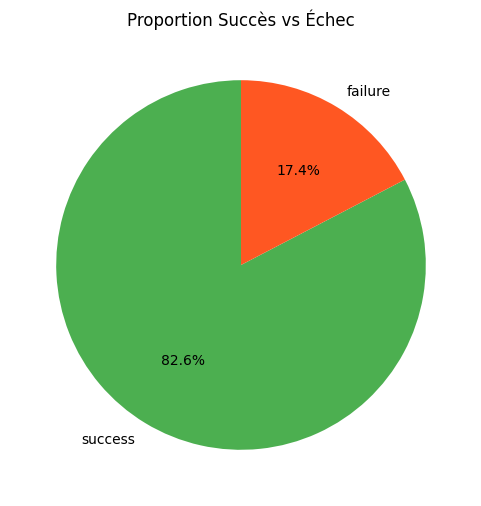

In [ ]:
# Calculer le pourcentage de succès et d'échecs
status_counts = df['status'].value_counts()
status_percentages = df['status'].value_counts(normalize=True) * 100

print("\n--- Fréquence des Statuts de Pipeline ---")
print(status_counts)
print("\n--- Pourcentage ---")
print(status_percentages)

# Visualisation (Optionnel mais recommandé dans le Notebook)
plt.figure(figsize=(6, 6))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=90, colors=['#4CAF50', '#FF5722'])
plt.title('Proportion Succès vs Échec')
plt.show()

In [ ]:
import pandas as pd
from ydata_profiling import ProfileReport
import os

# --- ÉTAPE 1 : Chargement du Fichier ---
# Assurez-vous que le fichier est présent dans l'environnement de travail de Colab
file_path = 'ci_cd_prediction_mock_2057_errors.csv' # MODIFICATION ICI : Correction du nom du fichier
df = pd.read_csv(file_path)

# --- ÉTAPE 2 : Analyse Rapide (Validation Data Manager) ---

print("--- 1. Vérification du Chargement ---")
print(f"✅ Nombre total de lignes chargées : {len(df)}")
print(f"✅ Premières lignes pour inspection :")
print(df.head())

print("\n--- 2. Vérification des Types de Colonnes ---")
print(df.dtypes)
print(f"✅ Types de 'duration_s' (cible) : {df['duration_s'].dtype} (Doit être 'int' ou 'float')")
print(f"✅ Types de 'start_time' (temps) : {df['start_time'].dtype} (Doit être 'object' ou 'datetime')")


# --- ÉTAPE 3 : Créer et Afficher le Rapport de Profilage (Rapport de Santé) ---

# Créer un rapport
profile = ProfileReport(
    df,
    title="Rapport de Profilage Colab | Validation CI/CD",
    html={'style': {'full_width': True}},
    # Options rapides de configuration (ajuster si nécessaire)
    sort=None,
    explorative=True
)

# Afficher le rapport directement dans le Notebook Colab
profile

--- 1. Vérification du Chargement ---
✅ Nombre total de lignes chargées : 2057
✅ Premières lignes pour inspection :
  workflow_id           start_time  duration_s   status  pred_duration_s  \
0      W-0001  2025-10-20 00:00:17         405  success              390   
1      W-0002  2025-10-20 00:08:25         737  success              730   
2      W-0003  2025-10-20 00:17:26         527  success              511   
3      W-0004  2025-10-20 00:25:12         231  success              231   
4      W-0005  2025-10-20 00:34:54         582  success              583   

   pred_risk_fail   branch_name    repo_name  code_lines_changed env_type  \
0        0.140458          main  repo-mobile                 304  staging   
1        0.125000          main   repo-front                 717  staging   
2        0.075229  feature-auth     repo-api                 528      dev   
3        0.041860  feature-auth  repo-mobile                 101  staging   
4        0.135447        hotfix     repo-a

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 11/11 [00:00<00:00, 46.30it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
import sys

# Installer la bibliothèque ydata-profiling
!{sys.executable} -m pip install ydata-profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.3/399.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd

# Définition des variables cibles (y) et des variables explicatives (X)
colonnes_a_exclure = ['workflow_id', 'pred_duration_s', 'pred_risk_fail', 'start_time']
X = df.drop(columns=['duration_s'] + colonnes_a_exclure)
y = df['duration_s']

# Encodage des Variables Catégorielles
colonnes_categoriques = ['status', 'branch_name', 'repo_name', 'env_type', 'error_tag']
X_encoded = pd.get_dummies(X, columns=colonnes_categoriques, drop_first=True)

# Séparation en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)
# Entraînement du modèle
model_rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model_rf.fit(X_train, y_train)

# Évaluation (pour confirmer la performance)
y_pred_rf = model_rf.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\n--- Nouvelle Performance Forêt Aléatoire ---")
print(f"Erreur Absolue Moyenne (MAE): {mae_rf:.2f}")
print(f"Coefficient R-carré (R2): {r2_rf:.4f}")


--- Nouvelle Performance Forêt Aléatoire ---
Erreur Absolue Moyenne (MAE): 32.67
Coefficient R-carré (R2): 0.9590


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Initialisation et entraînement du modèle Linéaire
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)

# 2. Prédiction sur l'ensemble de test
y_pred_linear = model_linear.predict(X_test)

# 3. Évaluation de la performance
mae = mean_absolute_error(y_test, y_pred_linear)
r2 = r2_score(y_test, y_pred_linear)

print("\n--- Performance du Modèle de Régression Linéaire (Baseline) ---")
print(f"Erreur Absolue Moyenne (MAE): {mae:.2f}")
print(f"Coefficient R-carré (R2): {r2:.4f}")


--- Performance du Modèle de Régression Linéaire (Baseline) ---
Erreur Absolue Moyenne (MAE): 30.34
Coefficient R-carré (R2): 0.9672


In [ ]:
import pandas as pd

# Créer un DataFrame pour les coefficients
coefficients = pd.Series(
    model_linear.coef_,
    index=X_train.columns
).sort_values(ascending=False)

print("\n--- Top 10 des Coefficients d'Influence (Régression Linéaire) ---")
print(coefficients.head(10))


--- Top 10 des Coefficients d'Influence (Régression Linéaire) ---
branch_name_hotfix             6.997250
repo_name_repo-mobile          4.951819
branch_name_feature-payment    3.306360
repo_name_repo-front           2.062193
code_lines_changed             0.802444
branch_name_main               0.546611
env_type_staging               0.477538
error_tag_TestFail            -0.138007
env_type_prod                 -0.220539
status_success                -0.323794
dtype: float64


In [ ]:
import joblib
import os
import numpy as np

# 1. Définir le nom du fichier de sauvegarde
model_filename = 'linear_regression_final_model.joblib'

# 2. Sauvegarder l'objet Python 'model_linear' sur le disque
# Le modèle entraîné est maintenant un fichier binaire
joblib.dump(model_linear, model_filename)

print(f"✅ Modèle sauvegardé avec succès sous : '{model_filename}'")

✅ Modèle sauvegardé avec succès sous : 'linear_regression_final_model.joblib'


In [ ]:
import joblib
import pandas as pd
import numpy as np

# 1. Charger le modèle sauvegardé
model_loaded = joblib.load('linear_regression_final_model.joblib')

# Récupérer les colonnes de X_train pour s'assurer de l'ordre et des colonnes présentes
feature_columns = X_train.columns

# Définir les variables catégorielles (doit correspondre à la liste utilisée pour l'entraînement)
colonnes_categoriques = ['status', 'branch_name', 'repo_name', 'env_type', 'error_tag']

# --- Préparation de la nouvelle donnée pour la prédiction ---

# 2. Créer un DataFrame pour le nouveau point de donnée avec les colonnes originales
new_observation_raw = pd.DataFrame({
    'code_lines_changed': [500],
    'status': ['success'], # Valeur réelle pour 'status'
    'branch_name': ['develop'], # Valeur réelle pour 'branch_name'
    'repo_name': ['repo-api'], # Valeur réelle pour 'repo_name'
    'env_type': ['dev'], # Valeur réelle pour 'env_type'
    'error_tag': ['None'] # Valeur réelle pour 'error_tag'
})

# 3. Appliquer le One-Hot Encoding au nouveau point de donnée, avec drop_first=True
new_observation_encoded = pd.get_dummies(new_observation_raw, columns=colonnes_categoriques, drop_first=True)

# 4. Aligner les colonnes du nouveau point de donnée encodé avec les colonnes utilisées pour l'entraînement (X_train)
# Les colonnes manquantes seront remplies avec 0, et les colonnes supplémentaires (si elles apparaissent en raison de get_dummies)
# qui n'étaient pas dans X_train seront supprimées.
new_data_point = new_observation_encoded.reindex(columns=feature_columns, fill_value=0)

# Assurez-vous que toutes les colonnes numériques sont du bon type pour correspondre à X_train
for col in feature_columns:
    if col in new_data_point.columns:
        new_data_point[col] = new_data_point[col].astype(X_train[col].dtype)

# 5. Exécuter la prédiction sur la nouvelle ligne de données
predicted_duration = model_loaded.predict(new_data_point)

# 6. Afficher le résultat
print("\n--- Résultat de la Prédiction ---")
print(f"Durée prédite du pipeline avec 500 lignes de changement : {predicted_duration[0]:.2f} secondes")
print(f"Soit environ {predicted_duration[0] / 60:.2f} minutes.")


--- Résultat de la Prédiction ---
Durée prédite du pipeline avec 500 lignes de changement : 516.39 secondes
Soit environ 8.61 minutes.
